In [14]:
import pandas as pd

# Cell 2: Load CSV (update path if needed)
csv_path = "wandb_export_2025-08-20T15_14_28.617-04_00.csv"
df = pd.read_csv(csv_path)

# Basic info
print(f"Loaded CSV with {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Loaded CSV with 18 rows and 93 columns


,Name,Tags,State,Notes,User,Created,Runtime,Sweep,accelerator,adata_path,...,real-test/recall,real-test/silhouette_score,real-train/accuracy,real-train/age_r2,real-train/f1_score,real-train/precision,real-train/psi_pearson_corr,real-train/psi_spearman_corr,real-train/recall,real-train/silhouette_score
0,denim-wildflower-243,fast,finished,-,NaN,2025-08-19T15:15:41.000Z,7699,NaN,auto,/gpfs/commons/groups/knowles_lab/Karin/TMS_MOD...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,proud-haze-243,fast,finished,-,NaN,2025-08-19T15:15:41.000Z,5070,NaN,auto,/gpfs/commons/groups/knowles_lab/Karin/TMS_MOD...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,noble-dawn-242,temp,finished,-,NaN,2025-08-19T03:24:41.000Z,5892,NaN,auto,/gpfs/commons/groups/knowles_lab/Karin/TMS_MOD...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sunny-smoke-241,temp,finished,-,NaN,2025-08-18T20:50:48.000Z,6443,NaN,auto,/gpfs/commons/groups/knowles_lab/Karin/TMS_MOD...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sparkling-eon-227,fast,finished,-,NaN,2025-08-18T15:20:47.000Z,5294,NaN,auto,/gpfs/commons/groups/knowles_lab/Karin/TMS_MOD...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def plot_tagged_runs_for_metrics(frame: pd.DataFrame, tag_value: str, metrics: list[str]):
    """
    For each metric in `metrics`, draw a vertical bar chart of runs with that tag.
    - No x-axis labels
    - Legend below chart
    - Values shown above bars
    """
    sub = _subset_by_tag(frame, tag_value)
    if sub.empty:
        print(f"No rows tagged with '{tag_value}'.")
        return

    # Build legend labels
    sub["legend_label"] = sub.apply(_build_label, axis=1)

    for metric_col in metrics:
        if metric_col not in sub.columns:
            print(f"Skipping '{metric_col}' — column not found.")
            continue

        msub = sub.dropna(subset=[metric_col]).copy()
        if msub.empty:
            print(f"No values for '{metric_col}' with tag '{tag_value}'.")
            continue

        # Ensure numeric
        msub[metric_col] = pd.to_numeric(msub[metric_col], errors="coerce")
        msub = msub.dropna(subset=[metric_col])
        if msub.empty:
            continue

        # Sort bars by metric value (desc)
        msub = msub.sort_values(metric_col, ascending=False)

        # X positions
        x_positions = np.arange(len(msub))

        # Plot bars
        plt.figure(figsize=(12, 6))
        unique_labels = msub["legend_label"].unique().tolist()
        for lbl in unique_labels:
            idx = msub.index[msub["legend_label"] == lbl]
            pos = [list(msub.index).index(i) for i in idx]
            heights = msub.loc[idx, metric_col].values
            bars = plt.bar(pos, heights, label=lbl)

            # Add value labels above bars
            for p, h in zip(bars, heights):
                plt.text(
                    p.get_x() + p.get_width() / 2,
                    h,
                    f"{h:.3f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

        # Remove x-axis ticks/labels
        plt.xticks([])
        plt.xlabel("")  

        # Y label, title
        plt.ylabel(metric_col)
        plt.title(f"Encoder Comparison (tag='{tag_value}') — {metric_col}")

        # Legend below chart
        plt.legend(
            title="Encoder",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=3,
        )

        plt.tight_layout()
        plt.show()

   


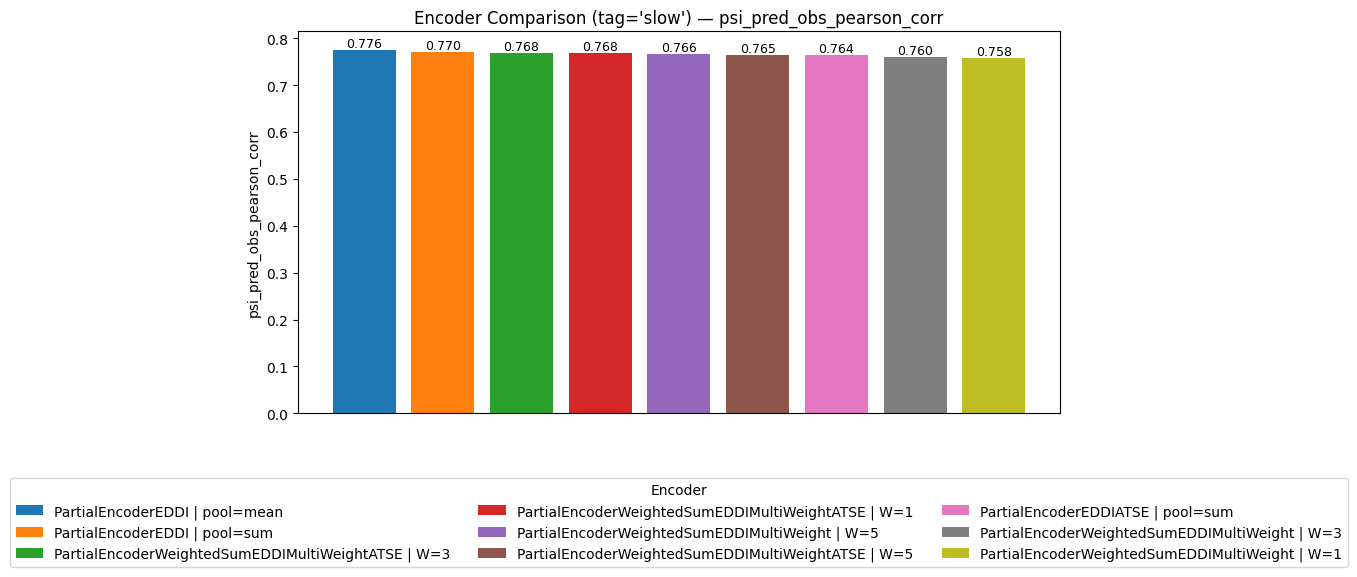

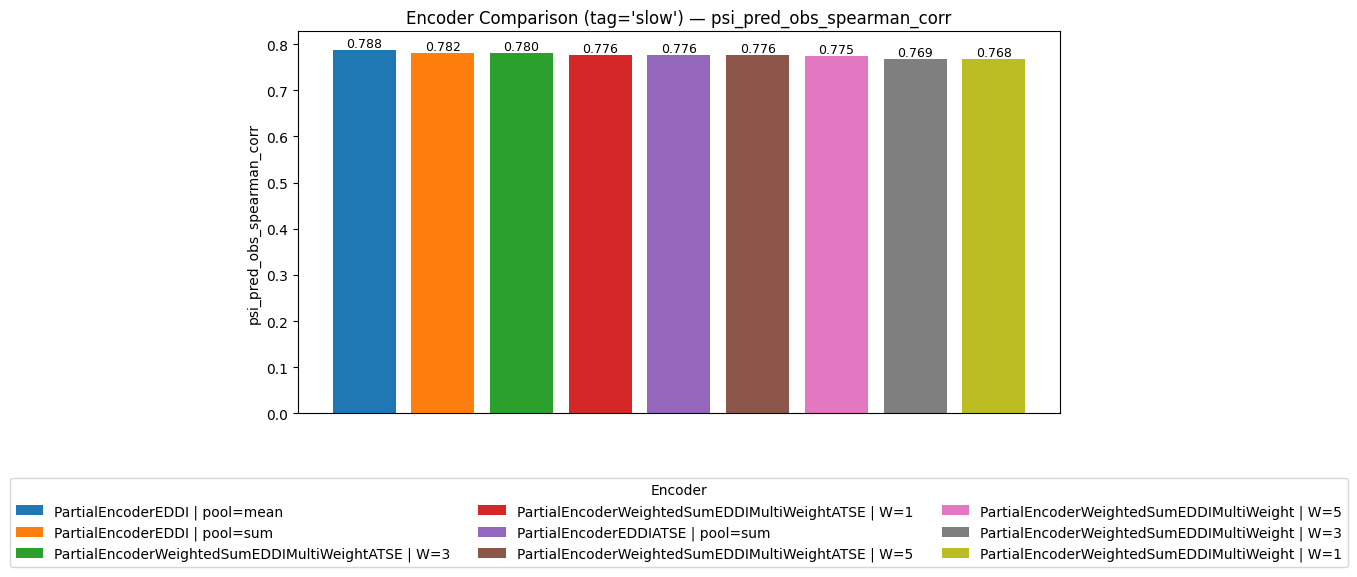

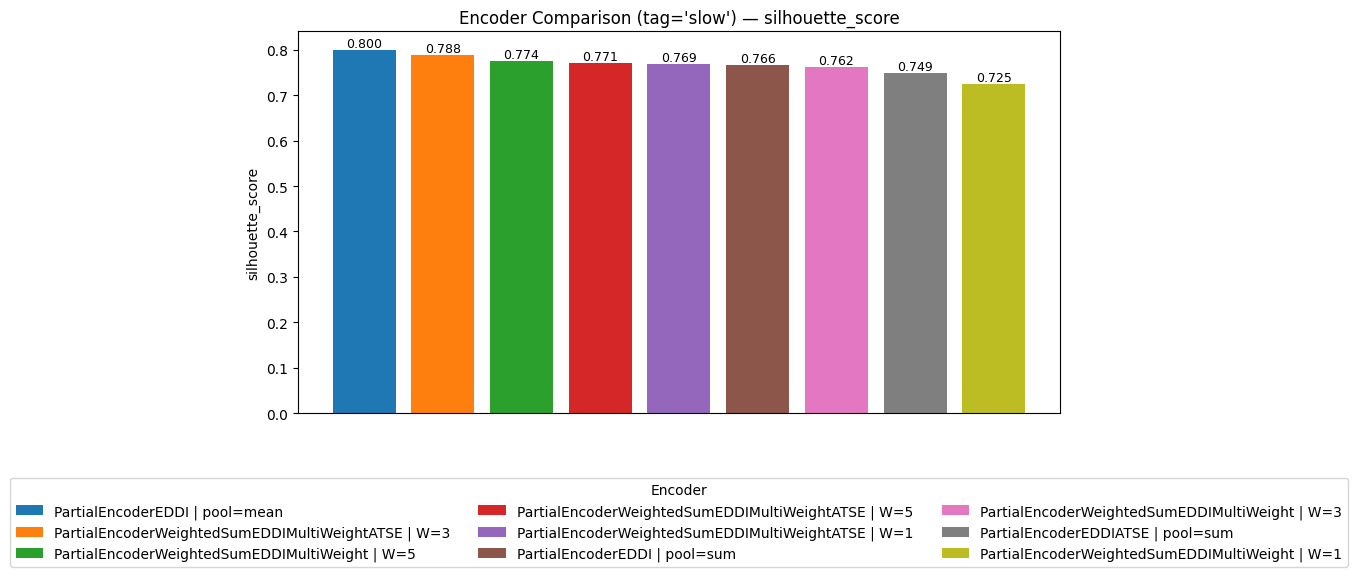

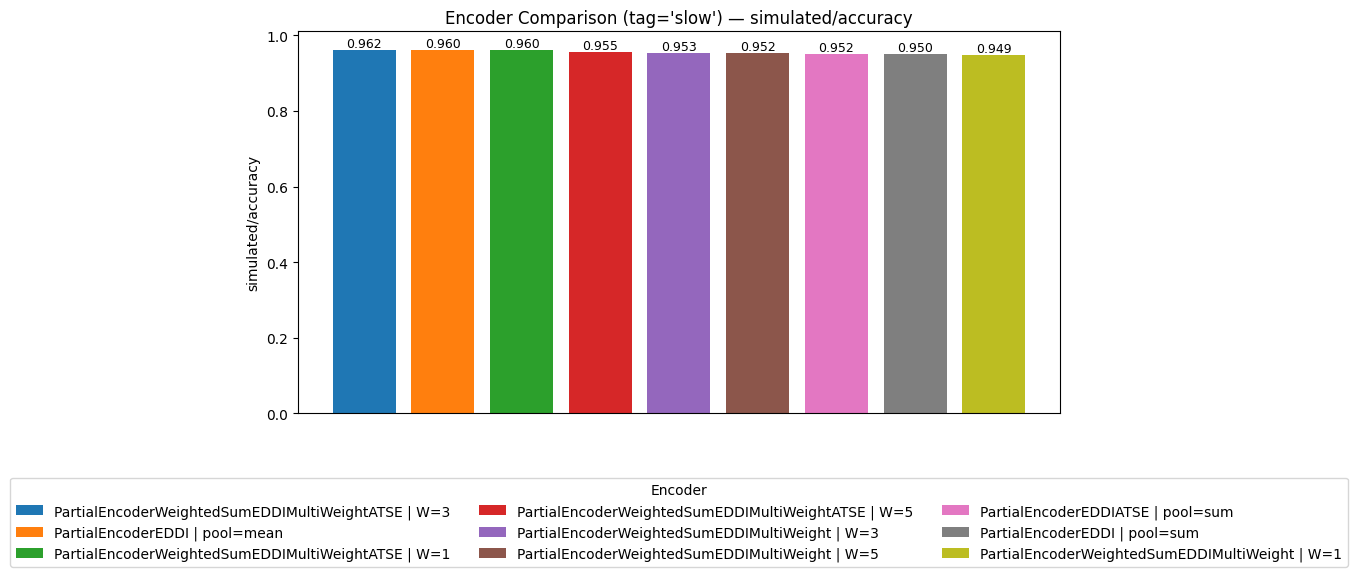

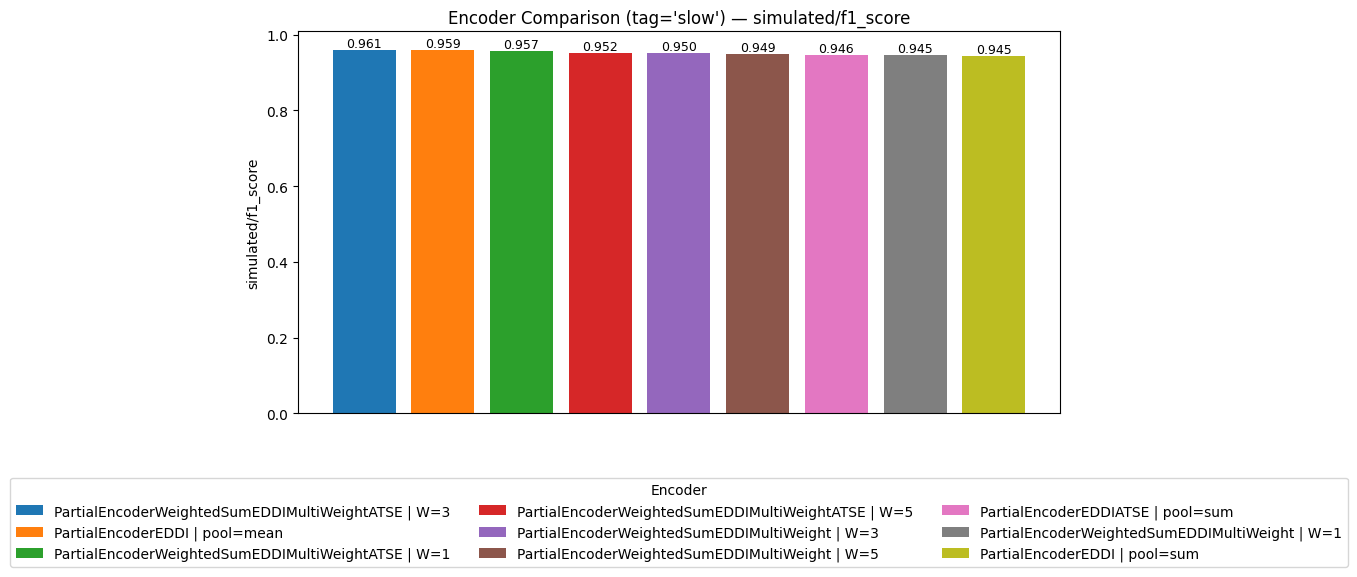

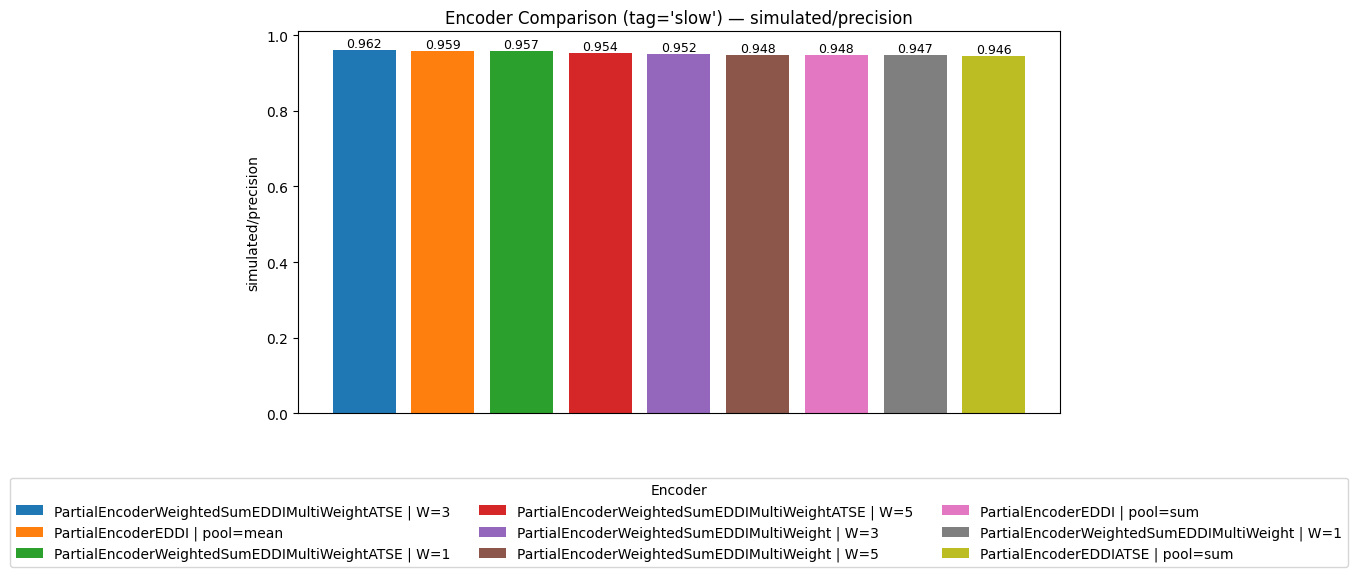

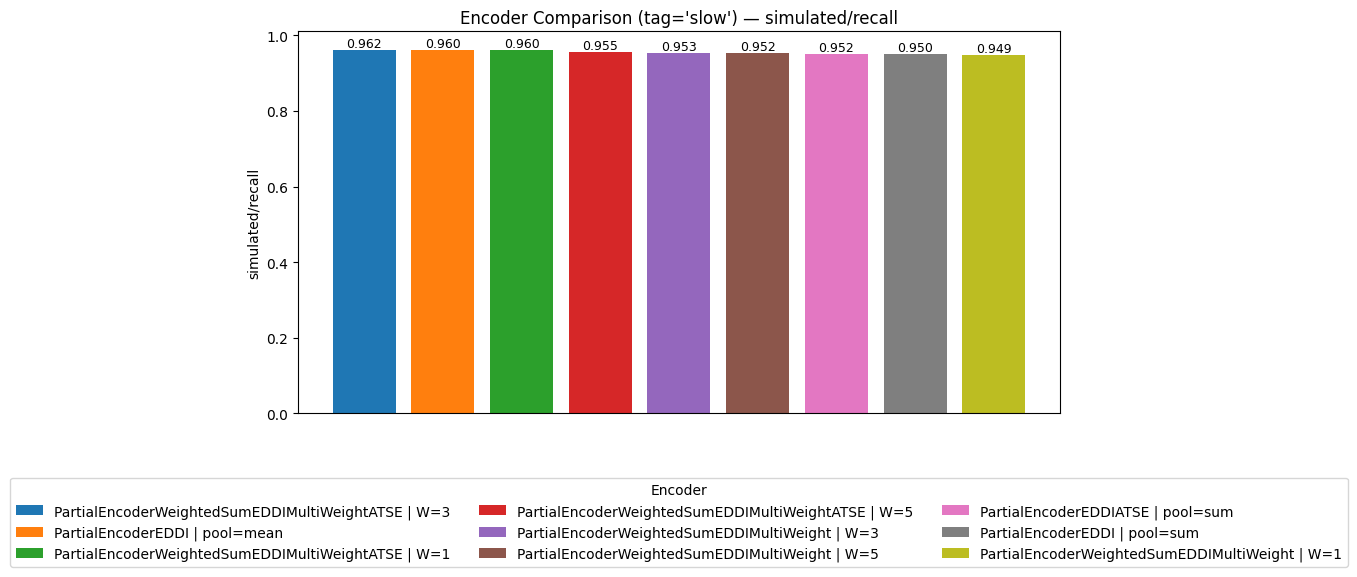

In [24]:
# Cell: Generate charts for FAST and SLOW tags

plot_tagged_runs_for_metrics(df, tag_value="slow", metrics=METRICS_TO_PLOT)


In [20]:
def plot_tagged_runs_for_metrics(frame: pd.DataFrame, tag_value: str, metrics: list[str]):
    """
    For each metric in `metrics`, draw a vertical bar chart of runs with that tag.
    - No x-axis labels
    - Legend below chart
    - Values shown above bars
    - For multi-weight encoders, legend shows W and temperature status/value.
    """
    sub = _subset_by_tag(frame, tag_value)
    if sub.empty:
        print(f"No rows tagged with '{tag_value}'.")
        return

    def _legend_with_temp(row: pd.Series) -> str:
        enc = str(row.get("encoder_type", "")).strip()
        parts = [enc] if enc else ["encoder"]
        enc_norm = enc.lower().replace("_", "").replace("-", "")

        # Multiweight: add W and temperature info
        if "multiweight" in enc_norm:
            # W
            nw = row.get("num_weight_vectors", np.nan)
            try:
                if pd.notna(nw):
                    parts.append(f"W={int(nw)}")
            except Exception:
                pass

            # Temperature
            t_fixed = row.get("temperature_fixed", None)
            t_val = row.get("temperature_value", row.get("temperature", None))

            if isinstance(t_fixed, (int, float)) and int(t_fixed) == -1:
                parts.append("T=fixed:1/sqrt(median_obs)")
            elif isinstance(t_fixed, (int, float, bool, str)):
                # Normalize truthy/falsy
                is_fixed = None
                if isinstance(t_fixed, str):
                    if t_fixed.strip().lower() in ("-1",):
                        parts.append("T=fixed:1/sqrt(median_obs)")
                    elif t_fixed.strip().lower() in ("1", "true", "yes", "y"):
                        is_fixed = True
                    else:
                        is_fixed = False
                else:
                    is_fixed = bool(t_fixed)

                if is_fixed:
                    if pd.notna(t_val):
                        try:
                            t_val_num = float(t_val)
                            parts.append(f"T=fixed:{t_val_num:.3f}")
                        except Exception:
                            parts.append(f"T=fixed:{t_val}")
                    else:
                        parts.append("T=fixed")
                else:
                    parts.append("T=1/sqrt(n_obs)")

        # Pool mode for exactly these encoders
        if enc in ("PartialEncoderEDDI", "PartialEncoderEDDIATSE"):
            pool = str(row.get("pool_mode", "")).strip()
            if pool:
                parts.append(f"pool={pool}")

        return " | ".join(parts)

    # Build legend labels
    sub["legend_label"] = sub.apply(_legend_with_temp, axis=1)

    for metric_col in metrics:
        if metric_col not in sub.columns:
            print(f"Skipping '{metric_col}' — column not found.")
            continue

        msub = sub.dropna(subset=[metric_col]).copy()
        if msub.empty:
            print(f"No values for '{metric_col}' with tag '{tag_value}'.")
            continue

        msub[metric_col] = pd.to_numeric(msub[metric_col], errors="coerce")
        msub = msub.dropna(subset=[metric_col])
        if msub.empty:
            continue

        msub = msub.sort_values(metric_col, ascending=False)
        x_positions = np.arange(len(msub))

        plt.figure(figsize=(12, 6))
        unique_labels = msub["legend_label"].unique().tolist()
        for lbl in unique_labels:
            idx = msub.index[msub["legend_label"] == lbl]
            pos = [list(msub.index).index(i) for i in idx]
            heights = msub.loc[idx, metric_col].values
            bars = plt.bar(pos, heights, label=lbl)

            # value labels
            for p, h in zip(bars, heights):
                plt.text(
                    p.get_x() + p.get_width() / 2,
                    h,
                    f"{h:.3f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

        plt.xticks([])
        plt.xlabel("")
        plt.ylabel(metric_col)
        plt.title(f"Encoder Comparison (tag='{tag_value}') — {metric_col}")

        plt.legend(
            title="Encoder",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=3,
        )

        plt.tight_layout()
        plt.show()



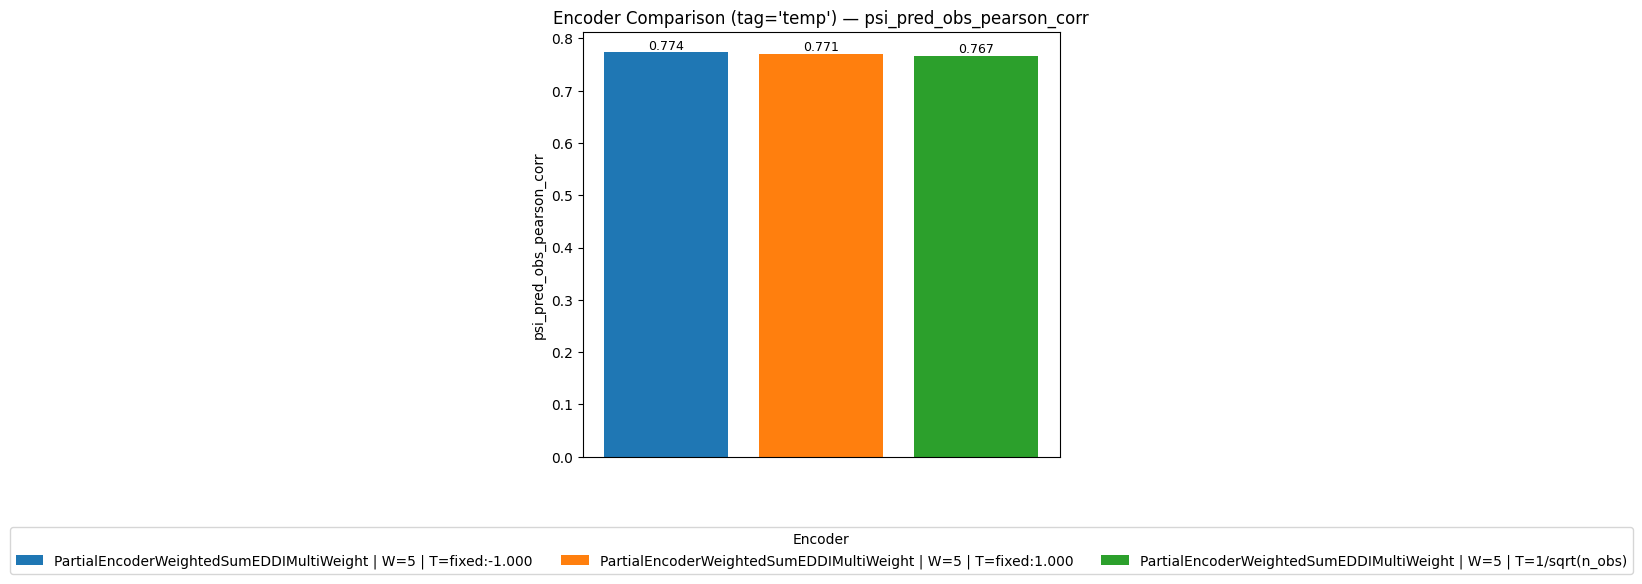

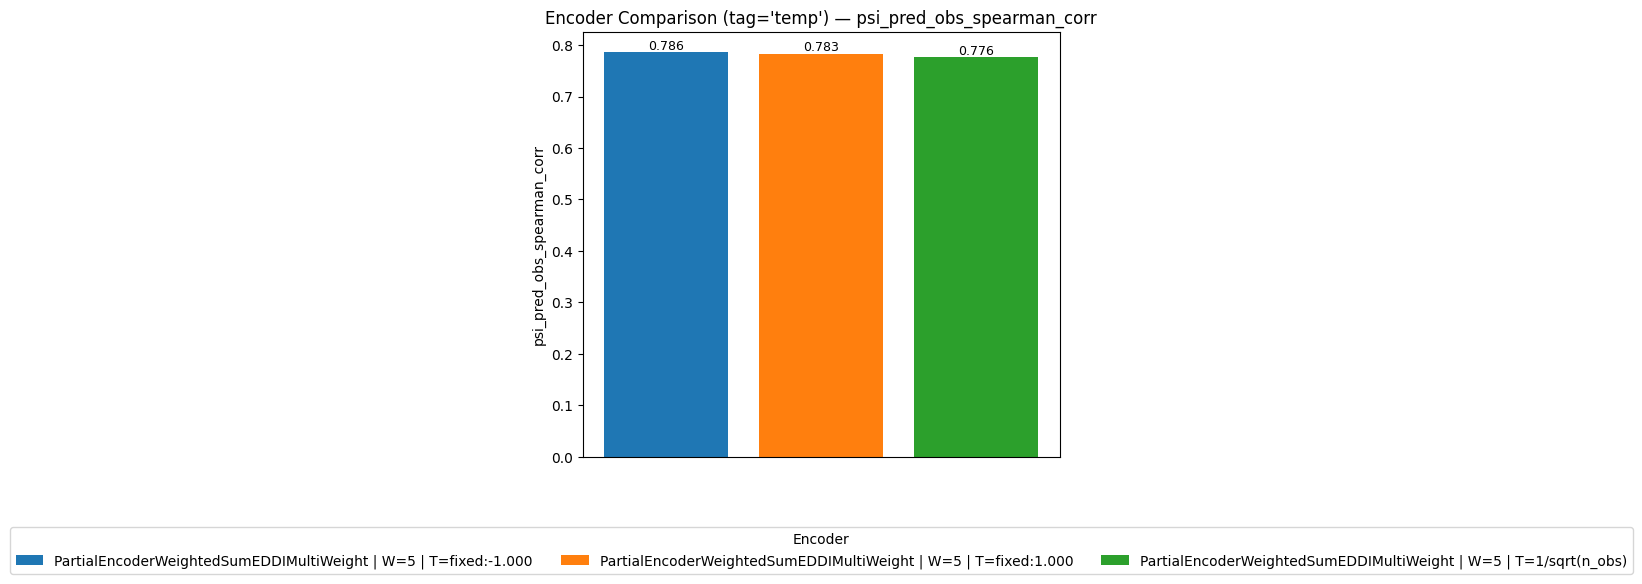

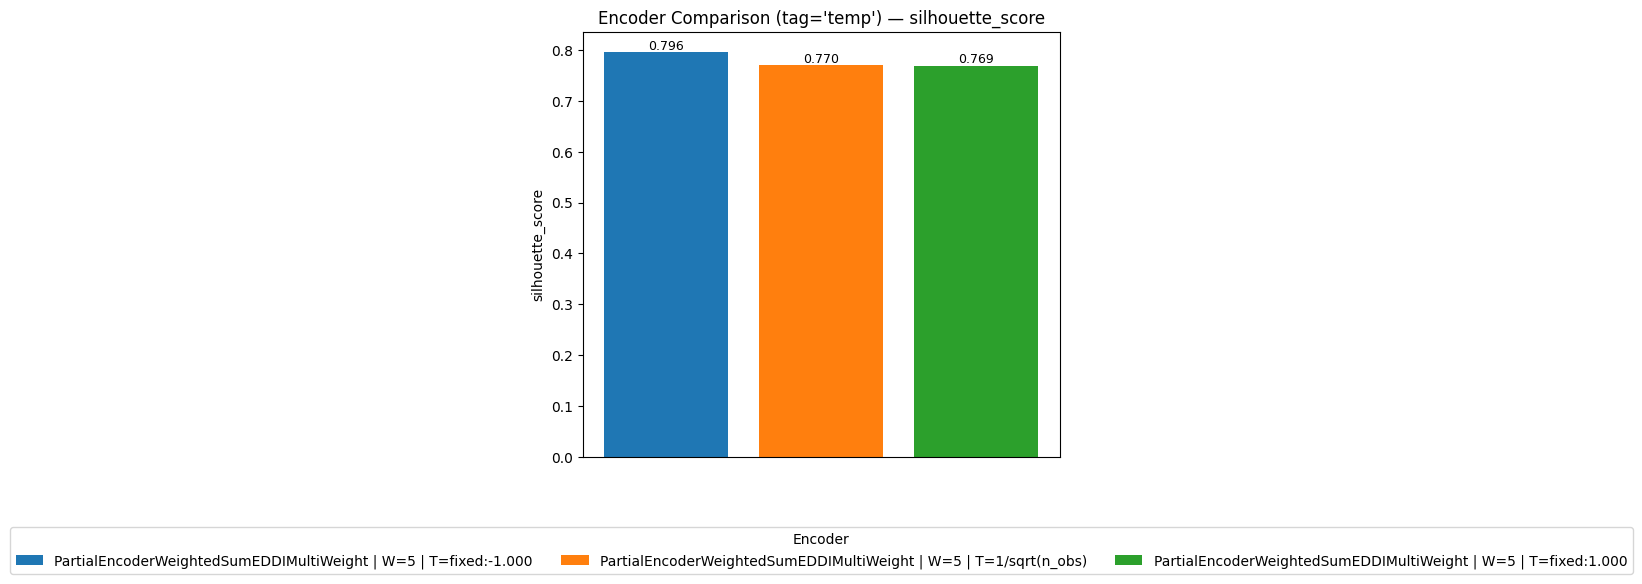

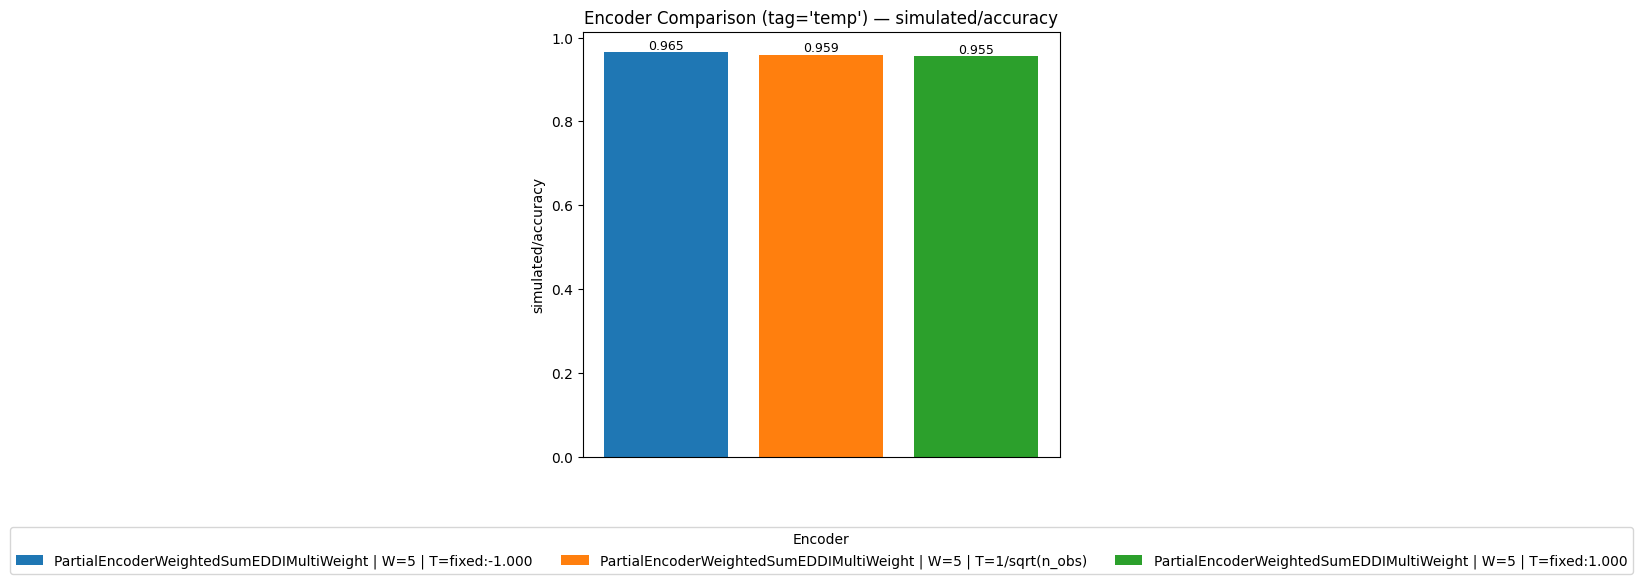

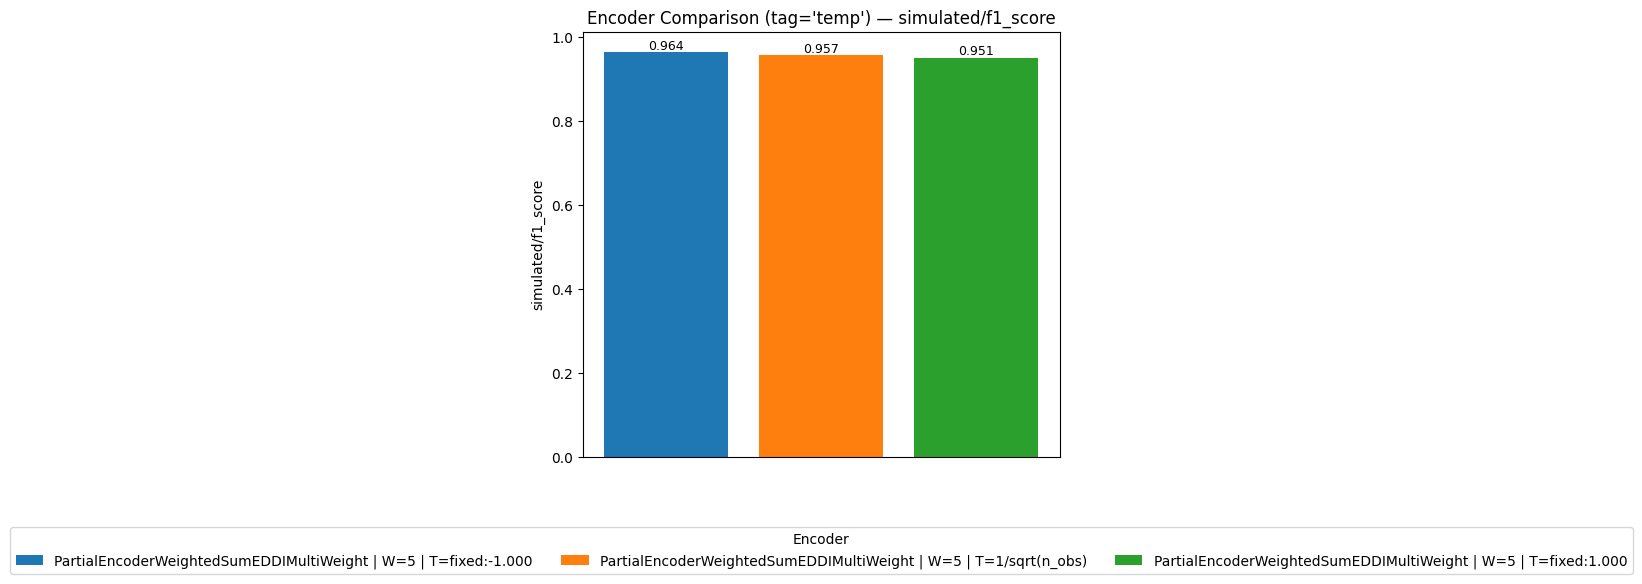

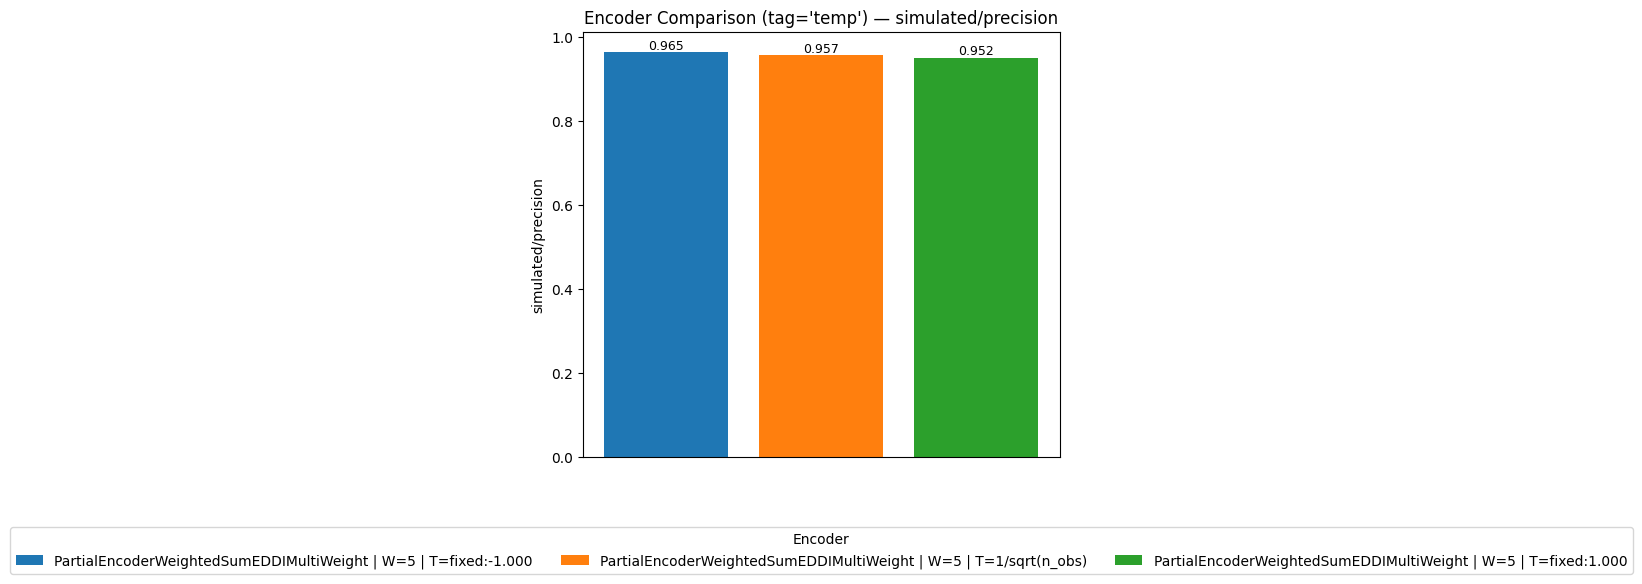

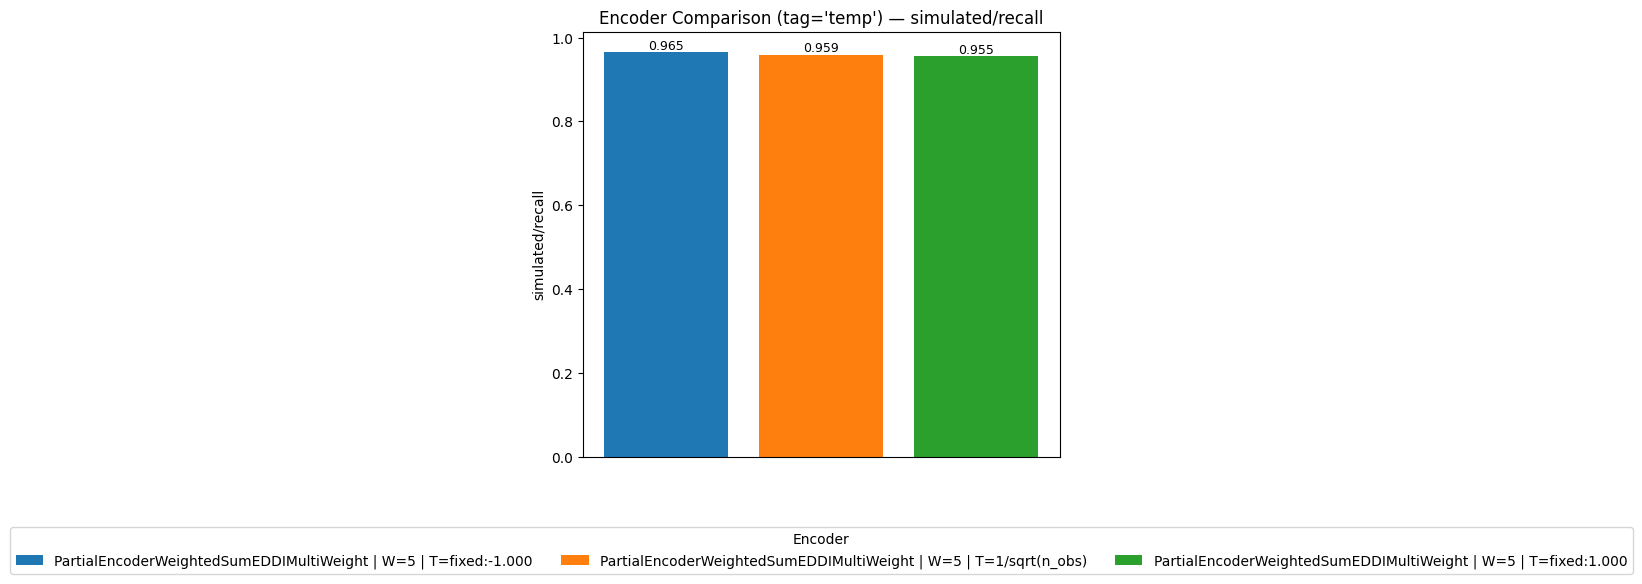

In [21]:
plot_tagged_runs_for_metrics(df, tag_value="temp", metrics=METRICS_TO_PLOT)


In [29]:
import math

def plot_tagged_runs_for_metrics(frame: pd.DataFrame, tag_value: str, metrics: list[str]):
    """
    Single figure with one legend:
      - One vertical bar subplot per metric in `metrics`
      - 2 subplots per row
      - Colors are consistent across metrics (color = run)
      - One legend at the bottom
      - No x-axis ticks/labels; values printed above bars
    """
    sub = _subset_by_tag(frame, tag_value)
    if sub.empty:
        print(f"No rows tagged with '{tag_value}'.")
        return

    # Build encoder-style legend label once
    sub["encoder_label"] = sub.apply(_build_label, axis=1)

    # Use run "Name" (fallback to index) to key colors and legend
    run_names = sub.get("Name", pd.Series([f"run{i+1}" for i in range(len(sub))], index=sub.index)).astype(str)
    sub["run_name"] = run_names

    # Keep only runs with at least one numeric metric
    valid_runs = []
    for ridx, row in sub.iterrows():
        for metric in metrics:
            if metric in sub.columns:
                val = pd.to_numeric(row[metric], errors="coerce")
                if pd.notna(val):
                    valid_runs.append(ridx)
                    break
    sub = sub.loc[valid_runs]
    if sub.empty:
        print(f"No plottable rows for tag '{tag_value}' across metrics {metrics}.")
        return

    # Consistent color per run
    unique_runs = sub["run_name"].unique().tolist()
    cmap = plt.get_cmap("tab20")
    colors = {run: cmap(i % 20) for i, run in enumerate(unique_runs)}

    # Legend labels
    legend_labels = {run: f"{run} — {lbl}"
                     for run, lbl in sub.set_index("run_name")["encoder_label"].items()}

    # Grid layout: 2 per row
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = math.ceil(n_metrics / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for i, metric_col in enumerate(metrics):
        ax = axes[i]

        if metric_col not in sub.columns:
            ax.set_visible(False)
            continue

        msub = sub.copy()
        msub[metric_col] = pd.to_numeric(msub[metric_col], errors="coerce")
        msub = msub.dropna(subset=[metric_col])
        if msub.empty:
            ax.set_visible(False)
            continue

        msub = msub.sort_values(metric_col, ascending=False)

        positions = np.arange(len(msub))
        heights = msub[metric_col].values
        run_order = msub["run_name"].tolist()

        barlist = ax.bar(positions, heights, color=[colors[r] for r in run_order])

        # Value labels above bars
        for p, h in zip(barlist, heights):
            ax.text(p.get_x() + p.get_width() / 2, h, f"{h:.3f}",
                    ha="center", va="bottom", fontsize=9)

        ax.set_title(metric_col)
        ax.set_ylabel(metric_col)
        ax.set_xticks([])
        ax.set_xlabel("")

    # Hide any unused subplot slots
    for j in range(len(metrics), len(axes)):
        axes[j].set_visible(False)

    # Overall title
    fig.suptitle(f"Encoder Comparison (tag='{tag_value}')", y=0.99, fontsize=14)

    # Legend below chart
    handles = [plt.Line2D([0], [0], marker='s', linestyle='',
                          color=colors[run], markersize=10)
               for run in unique_runs]
    labels = [legend_labels.get(run, run) for run in unique_runs]

    fig.legend(handles, labels, title="Run — Encoder",
               loc="upper center", bbox_to_anchor=(0.5, -0.02), ncol=3)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


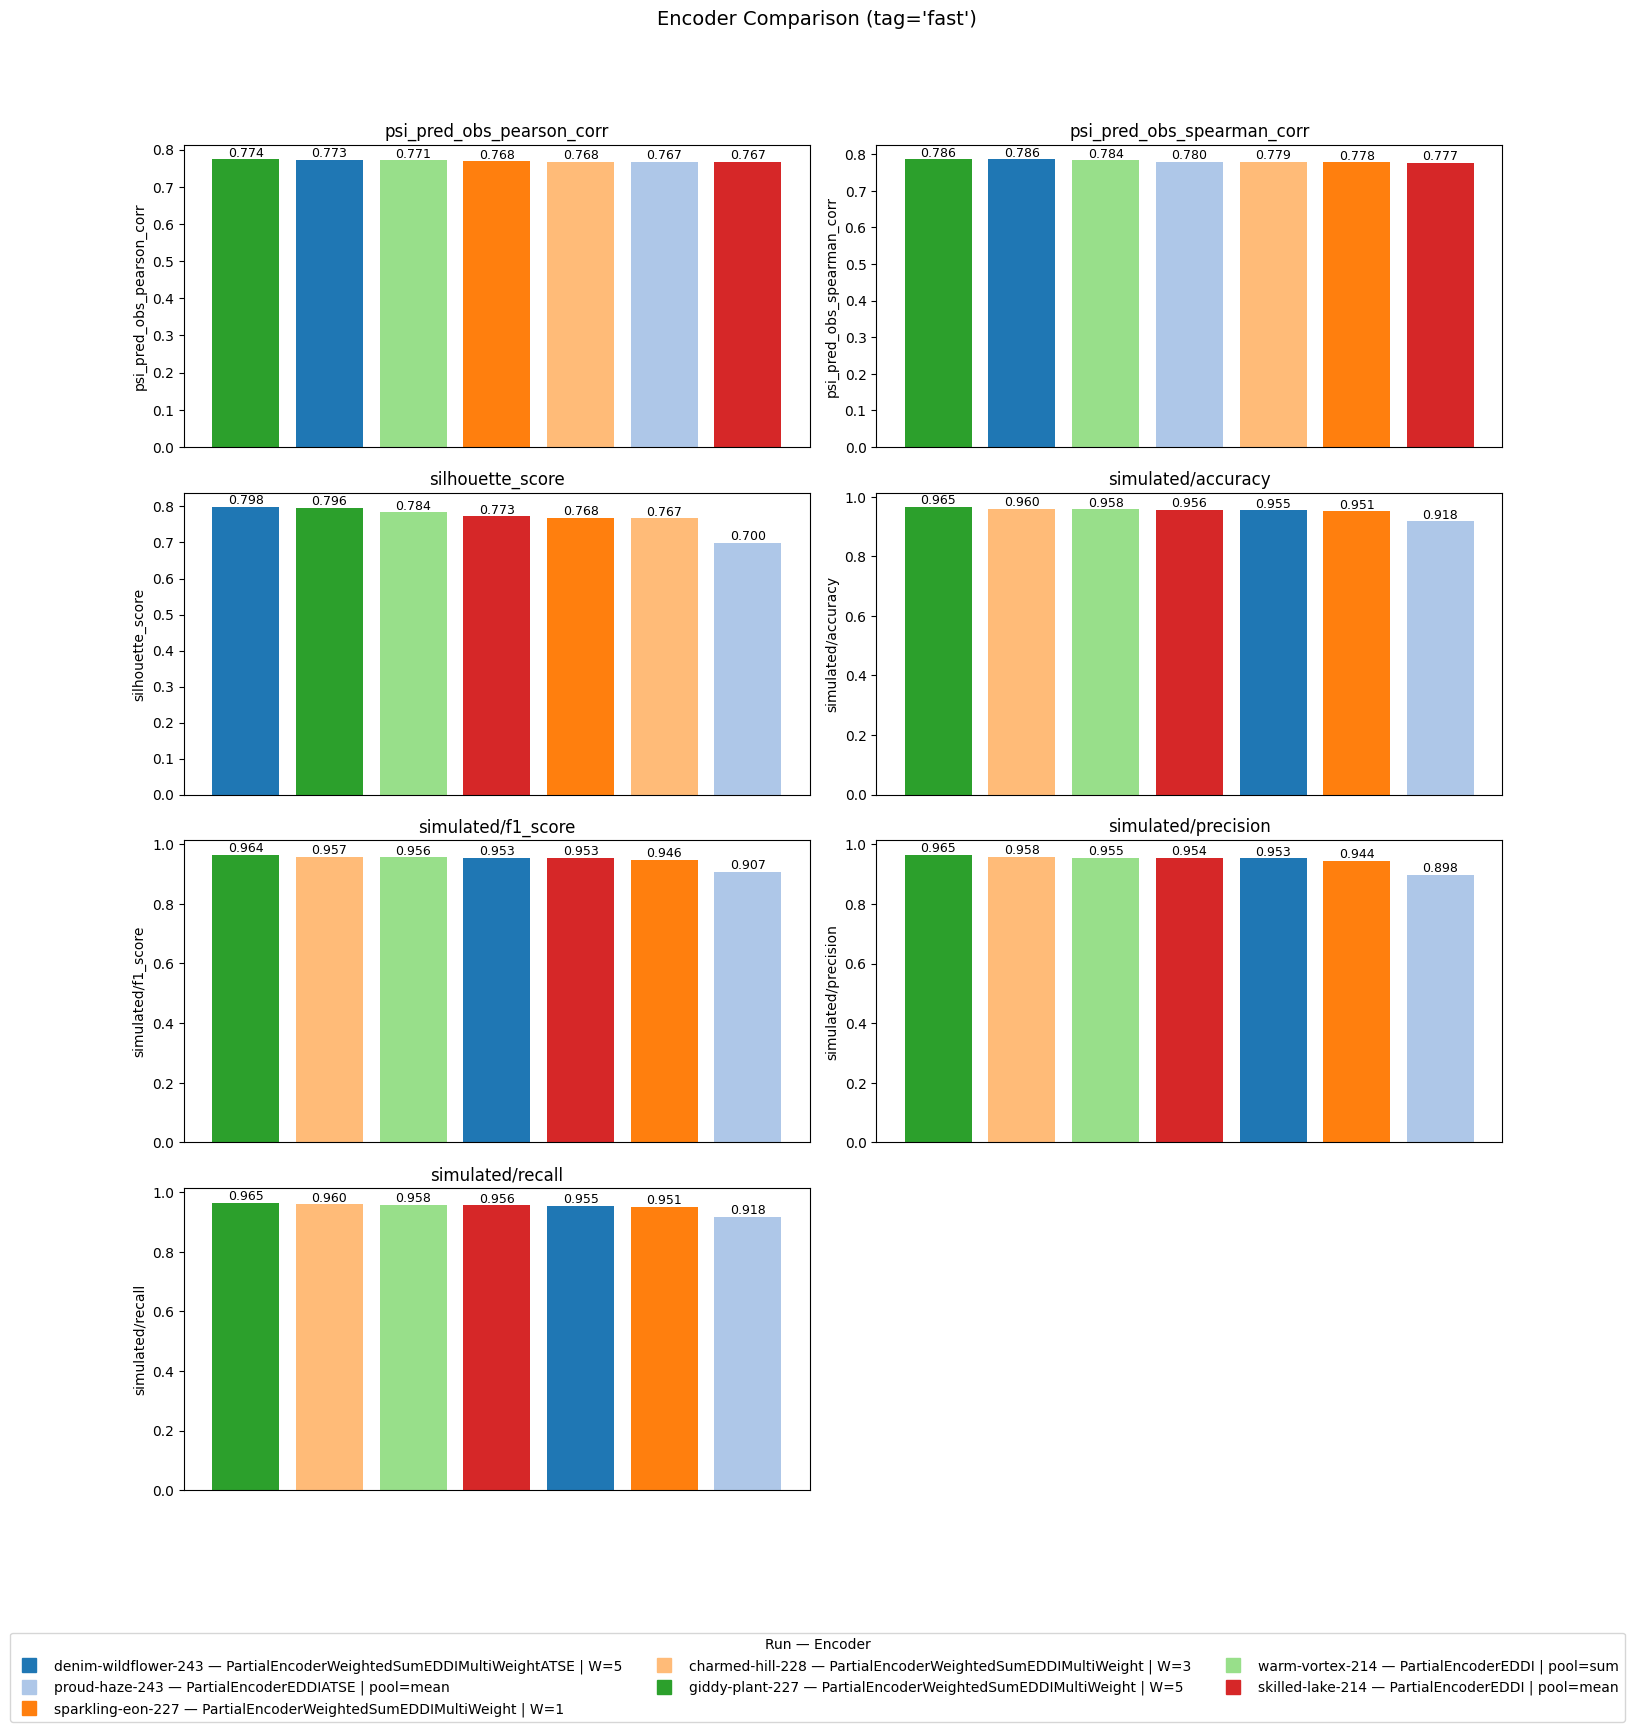

In [31]:

# and/or
plot_tagged_runs_for_metrics(df, tag_value="fast", metrics=METRICS_TO_PLOT)


In [36]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_tagged_runs_for_metrics(frame: pd.DataFrame, tag_value: str, metrics: list[str]):
    """
    Single figure with one legend:
      - One vertical bar subplot per metric in `metrics`
      - 2 subplots per row
      - Colors are consistent across metrics (color = run)
      - One legend at the bottom
      - No x-axis ticks/labels; values printed above bars
      - Multiweight encoders show W and temperature status in legend:
          * temperature_fixed == -1 -> 'T=fixed:1/sqrt(median_obs)'
          * temperature_fixed truthy -> 'T=fixed:<value>' (uses temperature_value or temperature)
          * temperature_fixed falsy -> 'T=1/sqrt(n_obs)'
      - For PartialEncoderEDDI / PartialEncoderEDDIATSE, pool mode is appended.
    """
    # --- helpers ---
    def _subset_by_tag(df: pd.DataFrame, tag: str) -> pd.DataFrame:
        if "Tags" not in df.columns:
            return df.iloc[0:0].copy()
        pat = rf"\b{re.escape(tag)}\b"
        return df[df["Tags"].astype(str).str.contains(pat, case=False, na=False)].copy()

    def _legend_with_temp(row: pd.Series) -> str:
        enc = str(row.get("encoder_type", "")).strip()
        parts = [enc] if enc else ["encoder"]
        enc_norm = enc.lower().replace("_", "").replace("-", "")

        # Multiweight: add W and temperature info
        if "multiweight" in enc_norm:
            # W
            nw = row.get("num_weight_vectors", np.nan)
            try:
                if pd.notna(nw):
                    parts.append(f"W={int(nw)}")
            except Exception:
                pass

            # Temperature fields
            t_fixed = row.get("temperature_fixed", None)
            t_val = row.get("temperature_value", row.get("temperature", None))

            # Case 1: fixed == -1  → fixed to 1/sqrt(median_obs)
            if (isinstance(t_fixed, (int, float)) and int(t_fixed) == -1) or (
                isinstance(t_fixed, str) and t_fixed.strip() == "-1"
            ):
                parts.append("T=fixed:1/sqrt(median_obs)")
            else:
                # Normalize boolean-ish fixed flag
                is_fixed = None
                if isinstance(t_fixed, str):
                    tl = t_fixed.strip().lower()
                    if tl in ("1", "true", "yes", "y"):
                        is_fixed = True
                    elif tl in ("0", "false", "no", "n"):
                        is_fixed = False
                elif isinstance(t_fixed, (int, float, bool)):
                    is_fixed = bool(t_fixed)

                if is_fixed is True:
                    if pd.notna(t_val):
                        try:
                            parts.append(f"T=fixed:{float(t_val):.3f}")
                        except Exception:
                            parts.append(f"T=fixed:{t_val}")
                    else:
                        parts.append("T=fixed")
                elif is_fixed is False:
                    parts.append("T=1/sqrt(n_obs)")
                # if is_fixed is None, omit temp info silently

        # Pool mode for exactly these encoders
        if enc in ("PartialEncoderEDDI", "PartialEncoderEDDIATSE"):
            pool = str(row.get("pool_mode", "")).strip()
            if pool:
                parts.append(f"pool={pool}")

        return " | ".join(parts)

    # --- main ---
    sub = _subset_by_tag(frame, tag_value)
    if sub.empty:
        print(f"No rows tagged with '{tag_value}'.")
        return

    # Build legend label once (with temperature/pool info as needed)
    sub["encoder_label"] = sub.apply(_legend_with_temp, axis=1)

    # Use run "Name" (fallback to index) as run identifier
    run_names = sub.get("Name", pd.Series([f"run{i+1}" for i in range(len(sub))], index=sub.index)).astype(str)
    sub["run_name"] = run_names

    # Keep only runs with at least one numeric metric
    valid_idx = []
    for ridx, row in sub.iterrows():
        for metric in metrics:
            if metric in sub.columns:
                val = pd.to_numeric(row[metric], errors="coerce")
                if pd.notna(val):
                    valid_idx.append(ridx)
                    break
    sub = sub.loc[valid_idx]
    if sub.empty:
        print(f"No plottable rows for tag '{tag_value}' across metrics {metrics}.")
        return

    # Consistent color per run
    unique_runs = sub["run_name"].unique().tolist()
    cmap = plt.get_cmap("tab20")
    colors = {run: cmap(i % 20) for i, run in enumerate(unique_runs)}

    # Legend labels: "Run — Encoder label"
    # (Pick the first occurrence of each run name to define its encoder label)
    legend_labels = {}
    for run in unique_runs:
        first_row = sub[sub["run_name"] == run].iloc[0]
        legend_labels[run] = f"{run} — {first_row['encoder_label']}"

    # Grid layout: 2 per row
    n_metrics = len(metrics)
    n_cols = 4
    n_rows = math.ceil(n_metrics / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = np.array(axes).reshape(-1)  # flatten in case n_rows==1

    for i, metric_col in enumerate(metrics):
        ax = axes[i]

        if metric_col not in sub.columns:
            ax.set_visible(False)
            continue

        msub = sub.copy()
        msub[metric_col] = pd.to_numeric(msub[metric_col], errors="coerce")
        msub = msub.dropna(subset=[metric_col])
        if msub.empty:
            ax.set_visible(False)
            continue

        # Sort by metric desc (higher is better)
        msub = msub.sort_values(metric_col, ascending=False)

        positions = np.arange(len(msub))
        heights = msub[metric_col].values
        run_order = msub["run_name"].tolist()

        # Bars with run-consistent colors
        barlist = ax.bar(positions, heights, color=[colors[r] for r in run_order])

        # Value labels above bars
        for p, h in zip(barlist, heights):
            ax.text(p.get_x() + p.get_width() / 2, h, f"{h:.3f}",
                    ha="center", va="bottom", fontsize=9)

        ax.set_title(metric_col)
        ax.set_ylabel(metric_col)
        ax.set_xticks([])
        ax.set_xlabel("")

    # Hide any unused subplot slots
    for j in range(len(metrics), len(axes)):
        axes[j].set_visible(False)

    # Overall title
    fig.suptitle(f"Encoder Comparison (tag='{tag_value}')", y=0.99, fontsize=14)

    # Single legend at bottom
    handles = [plt.Line2D([0], [0], marker='s', linestyle='',
                          color=colors[run], markersize=10)
               for run in unique_runs]
    labels = [legend_labels.get(run, run) for run in unique_runs]

    fig.legend(handles, labels, title="Run — Encoder",
               loc="upper center", bbox_to_anchor=(0.5, -0.02), ncol=3)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


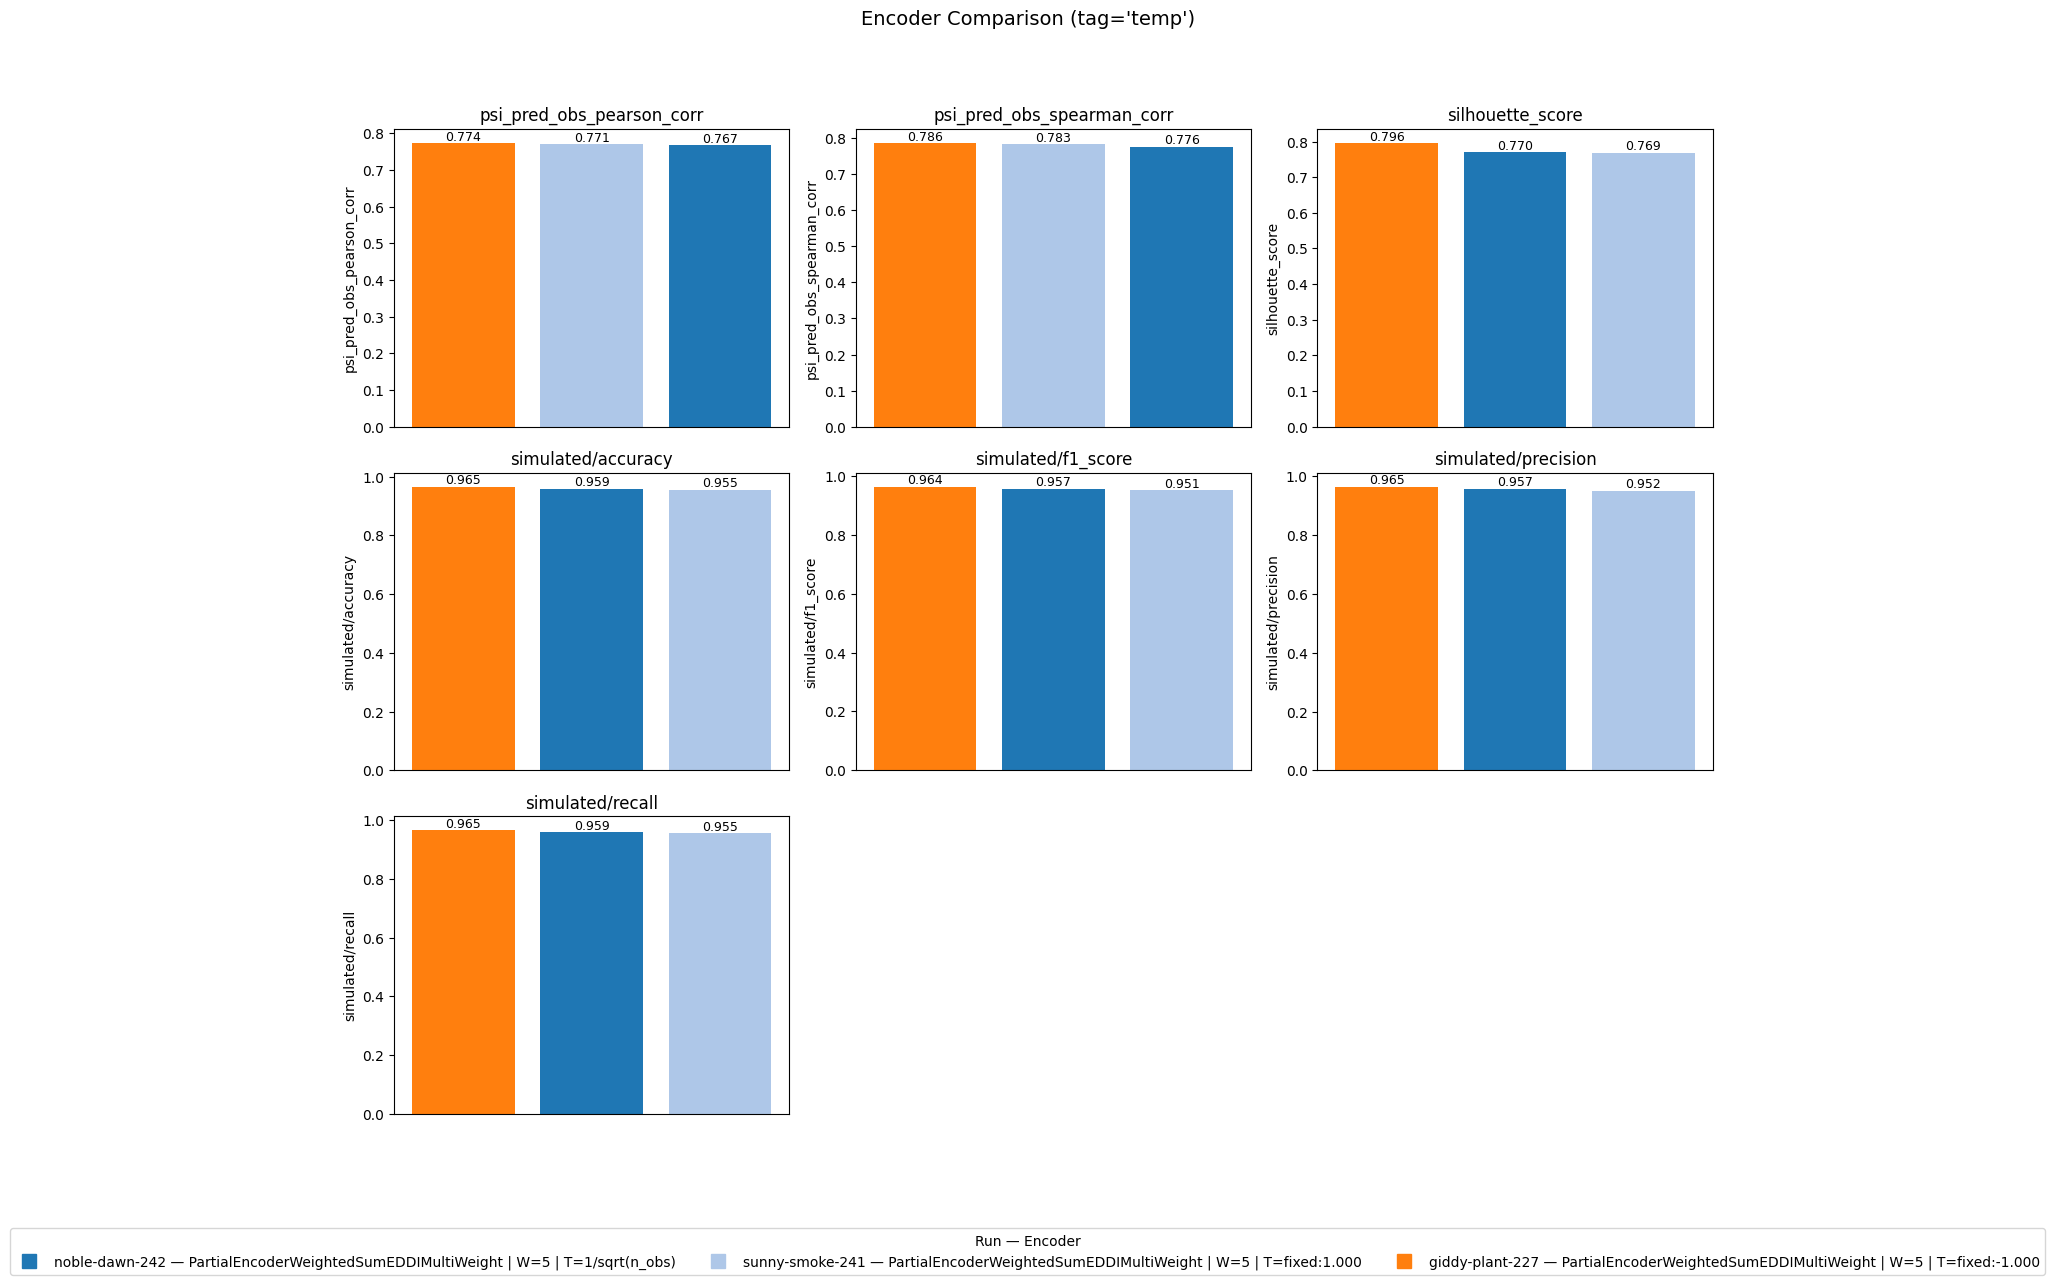

In [35]:
plot_tagged_runs_for_metrics(df, tag_value="temp", metrics=METRICS_TO_PLOT)
